## Chapter 1 - Multinomial BNs - Expert-based Networks

Train Survey

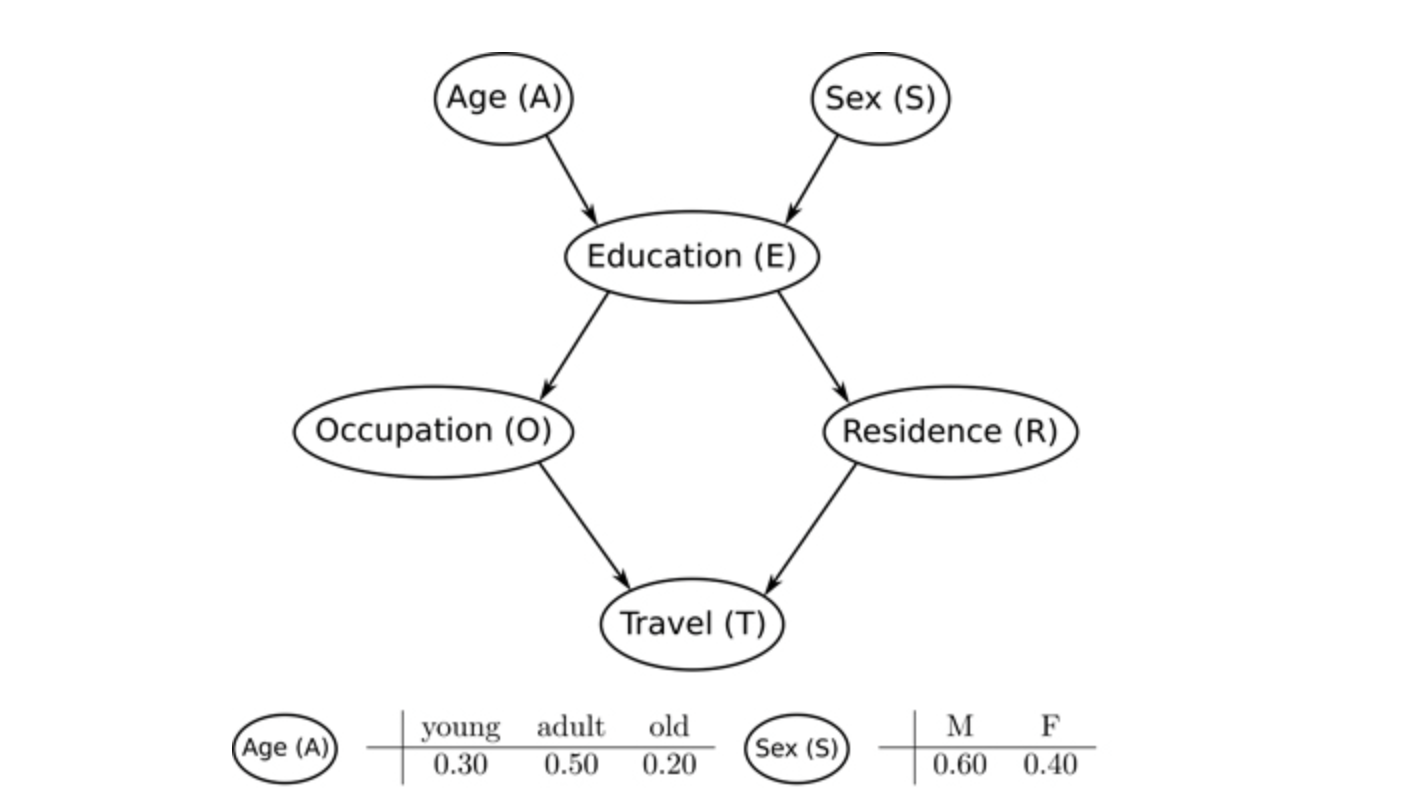

- Age - young, adult, old
- Sex - male, female
- Education - high (high-school), university degree
- Occupation - emp (employee), self-employed (self)
- Residence - city size: small, big
- Transportation - car, train, other

What we're going to do here is create the Bayesian Network in an expert style, meaning, we're not going to learn the parameter values from the data but just specify them (maybe we don't have information about the data but we do have information on the relationships).

In [4]:
install.packages(
  "bnlearn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)
library(bnlearn)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“dependencies ‘graph’, ‘Rgraphviz’ are not available”
also installing the dependencies ‘RcppEigen’, ‘RcppArmadillo’, ‘igraph’, ‘gRbase’, ‘gRain’, ‘Rmpfr’, ‘gmp’


Warning message in install.packages("bnlearn", repos = "https://cloud.r-project.org", :
“installation of package ‘gmp’ had non-zero exit status”
Warning message in install.packages("bnlearn", repos = "https://cloud.r-project.org", :
“installation of package ‘Rmpfr’ had non-zero exit status”


### create the graph

In [7]:
# create an empty graph
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))
dag


  Random/Generated Bayesian network

  model:
   [A][S][E][O][R][T] 
  nodes:                                 6 
  arcs:                                  0 
    undirected arcs:                     0 
    directed arcs:                       0 
  average markov blanket size:           0.00 
  average neighbourhood size:            0.00 
  average branching factor:              0.00 

  generation algorithm:                  Empty 


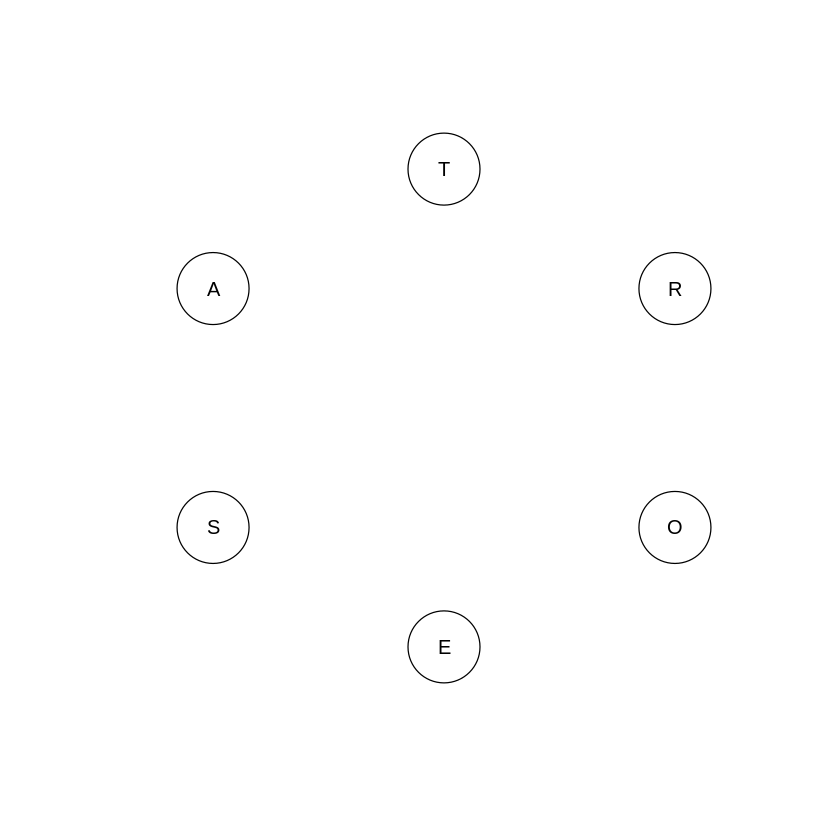

In [8]:
plot(dag)

In [9]:
dag <- set.arc(dag, from = "A", to = "E") # age influences education
dag <- set.arc(dag, from = "S", to = "E") # sex influences education
dag <- set.arc(dag, from = "E", to = "O") # ....
dag <- set.arc(dag, from = "E", to = "R") # ....
dag <- set.arc(dag, from = "O", to = "T") # ....
dag <- set.arc(dag, from = "R", to = "T") # ....

dag


  Random/Generated Bayesian network

  model:
   [A][S][E|A:S][O|E][R|E][T|O:R] 
  nodes:                                 6 
  arcs:                                  6 
    undirected arcs:                     0 
    directed arcs:                       6 
  average markov blanket size:           2.67 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  generation algorithm:                  Empty 


In [10]:
modelstring(dag)

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

In [11]:
nodes(dag)

[1] "A" "S" "E" "O" "R" "T"

In [12]:
arcs(dag)

from,to
A,E
S,E
E,O
E,R
O,T
R,T


In [13]:
dag2 <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))
arc.set <- matrix(c("A", "E",
                    "S", "E",
                    "E", "O",
                    "E", "R",
                    "O", "T",
                    "R", "T"), byrow = TRUE,
                    ncol = 2, dimnames = list(NULL, c("from", "to")))

arc.set

from,to
A,E
S,E
E,O
E,R
O,T
R,T


In [14]:
arcs(dag2) <- arc.set

In [15]:
dag2


  Random/Generated Bayesian network

  model:
   [A][S][E|A:S][O|E][R|E][T|O:R] 
  nodes:                                 6 
  arcs:                                  6 
    undirected arcs:                     0 
    directed arcs:                       6 
  average markov blanket size:           2.67 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  generation algorithm:                  Empty 


In [16]:
# allow us to compare two dags
all.equal(dag, dag2)

[1] TRUE

In [17]:
# if we try to add an edge that results in a cycle - ERROR
set.arc(dag, from = "T", to = "E")

ERROR: Error in arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles, : the resulting graph contains cycles.


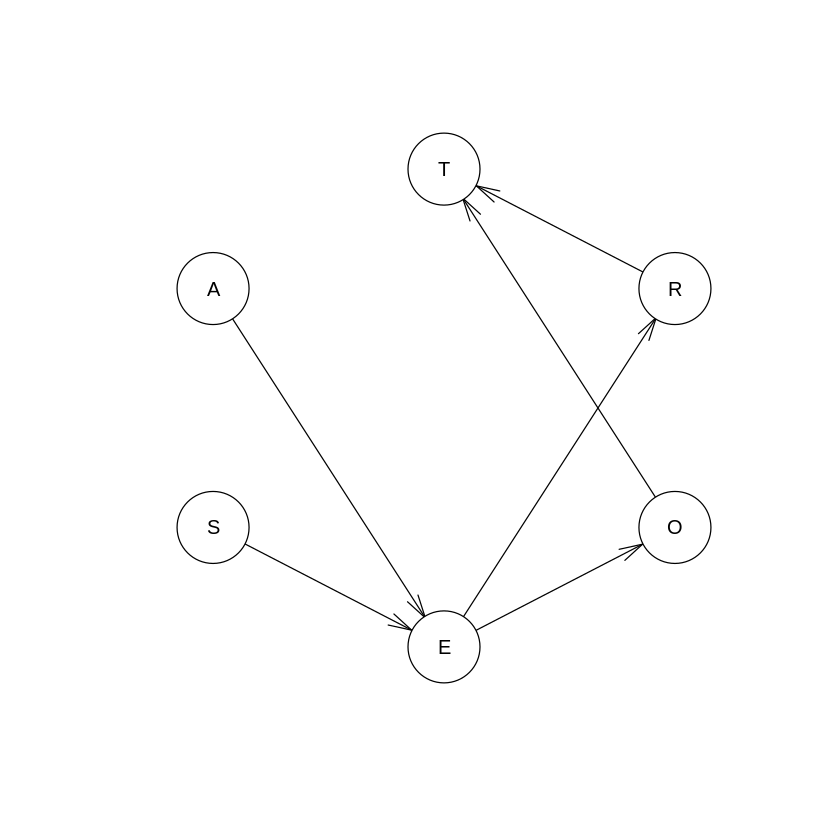

In [18]:
plot(dag)

### specify the probability distributions

In [19]:
# define the states
A.lv <- c("young", "adult", "old")
S.lv <- c("M", "F")
E.lv <- c("high", "uni")
O.lv <- c("emp", "self")
R.lv <- c("small", "big")
T.lv <- c("car", "train", "other")

In [27]:
# specify the CPT for every node ("Expert Defined")
A.prob <- array(c(0.30, 0.50, 0.20), dim = 3, dimnames = list(A = A.lv))
A.prob

A
young adult   old 
  0.3   0.5   0.2

In [28]:
S.prob <- array(c(0.60, 0.4), dim = 2, dimnames = list(S=S.lv))
S.prob

S
  M   F 
0.6 0.4

In [34]:
# O | E, occupation is dependent on education
O.prob <- array(c(0.96, 0.04,  0.92, 0.08),   # fill by column!
                dim = c(2, 2),                # 2 rows (O), 2 cols (E)
                dimnames = list(O = c("emp", "self"), E = E.lv))
O.prob

,high,uni
emp,0.96,0.92
self,0.04,0.08


In [30]:
# alternative way (aside)
o.cpt <- cbind(c(0.96, 0.04), c(.92, 0.08))
dimnames(o.cpt) = list(O = O.lv, E = E.lv)
o.cpt

,high,uni
emp,0.96,0.92
self,0.04,0.08


In [35]:
# R | E, residence is dependent on education
R.prob <- array(c(0.25, 0.75,  0.20, 0.80),   # small/big | E
                dim = c(2, 2),
                dimnames = list(R = c("small", "big"), E = E.lv))
R.prob

,high,uni
small,0.25,0.2
big,0.75,0.8


In [39]:
# E | A, S, education is dependent on age & sex
E.prob <- array(c(0.75, 0.25, # E | A = young, S = M
                  0.72, 0.28, # E | A = adult, S = M
                  0.88, 0.12, # E | A = old, S = M

                  0.64, 0.36,  # E | A = young, S = F
                  0.70, 0.30,  # E | A = adult, S = F
                  0.90, 0.10), # E | A = old, S = F

                dim = c(2, 3, 2), # 2Ex3Ax2S
                dimnames = list(E = E.lv,
                                A = A.lv,
                                S = S.lv))
E.prob

, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult old
  high  0.64   0.7 0.9
  uni   0.36   0.3 0.1

In [45]:
E.prob[, "young", "M"]  # high / uni given young male
# high 0.75  uni 0.25
E.prob[, "adult", "F"]  # high / uni given adult female
# high 0.70  uni 0.30

high  uni 
0.75 0.25

high  uni 
 0.7  0.3

In [40]:
# T | R, O, travel is dependent on occupation & residence
T.prob <- array(c(0.48, 0.42, 0.10,  # sums to 1
                  0.56, 0.36, 0.08,  # sums to 1

                  0.58, 0.24, 0.18,  # sums to 1
                  0.70, 0.21, 0.09), # sums to 1
                dim = c(3,2,2), # 3Tx2Ox2R
                dimnames = list(T=T.lv,
                                O = O.lv,
                                R = R.lv))
T.prob

, , R = small

       O
T        emp self
  car   0.48 0.56
  train 0.42 0.36
  other 0.10 0.08

, , R = big

       O
T        emp self
  car   0.58 0.70
  train 0.24 0.21
  other 0.18 0.09

In [46]:
T.prob[, , "small"]  # 3×2 matrix for small cities
T.prob[, , "big"]    # 3×2 matrix for big cities

,emp,self
car,0.48,0.56
train,0.42,0.36
other,0.10,0.08


,emp,self
car,0.58,0.70
train,0.24,0.21
other,0.18,0.09


In [21]:
# one more way to specify the dag
modelstring(dag)

dag3 <- model2network("[A][S][E|A:S][O|E][R|E][T|O:R]")

all.equal(dag,dag3)

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

[1] TRUE

### parameterize the network

In [41]:
cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob, T = T.prob)
bn <- custom.fit(dag, dist = cpt)
nparams(bn)

Warning message in nparams(bn):
“the effective argument is deprecated and will be removed in 2025.”


[1] 21

In [42]:
arcs(bn)

from,to
A,E
S,E
E,O
E,R
O,T
R,T


In [43]:
bn$T


  Parameters of node T (multinomial distribution)

Conditional probability table:
 
, , R = small

       O
T        emp self
  car   0.48 0.56
  train 0.42 0.36
  other 0.10 0.08

, , R = big

       O
T        emp self
  car   0.58 0.70
  train 0.24 0.21
  other 0.18 0.09


In [44]:
bn$E


  Parameters of node E (multinomial distribution)

Conditional probability table:
 
, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult  old
  high  0.64  0.70 0.90
  uni   0.36  0.30 0.10


In [25]:
bn


  Bayesian network parameters

  Parameters of node A (multinomial distribution)

Conditional probability table:
 A
young adult   old 
  0.3   0.5   0.2 

  Parameters of node S (multinomial distribution)

Conditional probability table:
 S
  M   F 
0.6 0.4 

  Parameters of node E (multinomial distribution)

Conditional probability table:
 
, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult  old
  high  0.64  0.70 0.90
  uni   0.36  0.30 0.10


  Parameters of node O (multinomial distribution)

Conditional probability table:
 
      E
O      high  uni
  emp  0.96 0.92
  self 0.04 0.08

  Parameters of node R (multinomial distribution)

Conditional probability table:
 
       E
R       high  uni
  small 0.25 0.20
  big   0.75 0.80

  Parameters of node T (multinomial distribution)

Conditional probability table:
 
, , R = small

       O
T        emp self
  car   0.48 0.56
  train 0.42 0.36
  other 0.10 0.08